# 第5章 顔類似画像検索システム


## 画像の準備

pexels-apiのインストール

In [1]:
!pip install pexels-api==1.0.1

Pexelsから画像のダウンロードを行う

In [2]:
import os

import requests
from pexels_api import API

PEXELS_API_KEY = "ここにPEXELSのAPI KEYを入れてください"  # ①

api = API(PEXELS_API_KEY)  # ②

def save_file(filename, content):
    with open(filename, mode="wb") as f:
        f.write(content)
        print(f"save {filename}")


def download(keyword, page_start, page_end): # ③
    os.makedirs("images", exist_ok=True)  # ④
    for page in range(page_start, page_end):
        results = api.search(keyword,
                             page=page,
                             results_per_page=50)  # ⑤
        photos = results["photos"]
        for photo in photos:
            image_id = photo["id"]
            image_url = photo["src"]["medium"]
            response = requests.get(image_url)  # ⑥
            filename = f"images/{image_id}.jpeg"
            save_file(filename, response.content)  # ⑦

キーワード「face」でページ1からページ30までダウンロードを行う

In [3]:
download("face", 1, 30)

save images/2709388.jpeg
save images/775358.jpeg
save images/3586798.jpeg
save images/1840608.jpeg
save images/1933873.jpeg
save images/3310695.jpeg
save images/3671083.jpeg
save images/4890733.jpeg
save images/1982852.jpeg
save images/3981337.jpeg
save images/3220360.jpeg
save images/2846602.jpeg
save images/3438086.jpeg
save images/3283568.jpeg
save images/2741701.jpeg
save images/3186558.jpeg
save images/3748221.jpeg
save images/3533228.jpeg
save images/2755165.jpeg
save images/2530775.jpeg
save images/2853198.jpeg
save images/5397723.jpeg
save images/4229083.jpeg
save images/5046546.jpeg
save images/6652928.jpeg
save images/6015909.jpeg
save images/4556737.jpeg
save images/4355346.jpeg
save images/5034475.jpeg
save images/4662950.jpeg
save images/4993292.jpeg
save images/2703181.jpeg
save images/5704720.jpeg
save images/5704849.jpeg
save images/4571943.jpeg
save images/4612113.jpeg
save images/4640886.jpeg
save images/2728264.jpeg
save images/4754648.jpeg
save images/4197932.jpeg
s

## FaceNetを使った特徴抽出

### MTCNNのインストール

In [4]:
!pip install mira==0.4.0

     |████████████████████████████████| 95 kB 3.9 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
  Created wheel for mira: filename=mira-0.4-cp37-cp37m-linux_x86_64.whl size=169652 sha256=07a8035252c1d3ddf67c876c3bc77e8156c430b4c65035d0dd01c85103555f29
  Stored in directory: /root/.cache/pip/wheels/e9/73/41/a079bcbf57e81b3a709534bfd417f40f470cfec2b7e925e6cb
Successfully built mira


### MTCNNを用いた顔検出

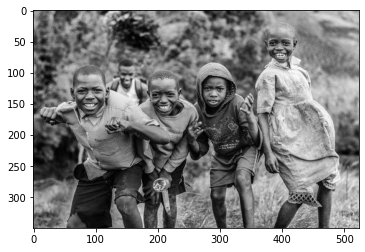

In [5]:
from mira import core

image = core.Image.read("images/1002061.jpeg")
image.show()

顔領域の検出

In [6]:
from mira import detectors

detector = detectors.MTCNN()
annotations = detector.detect(image)

アノテーションの可視化

/usr/local/lib/python3.7/dist-packages/mira/core/scene.py:209: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  bbox_inches='tight')


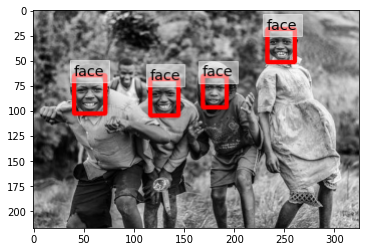

In [7]:
scene = core.Scene(
    annotations=annotations,
    image=image,
    annotation_config=detector.annotation_config
)
scene.show()

顔画像を切り取る

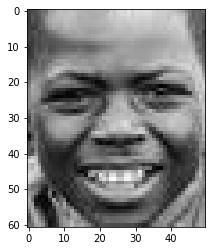

In [8]:
annotation = annotations[0]
cropped = annotation.selection.extract(image)
cropped.show()

### FaceNetのインストール

In [9]:
!pip install keras_facenet==0.3.2

     |████████████████████████████████| 2.3 MB 13.0 MB/s 
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10386 sha256=688d9562d1d106c23ac92addc79a6bf61273ac24fd4ca56501878cbe38658878
  Stored in directory: /root/.cache/pip/wheels/2b/76/1a/a29ceb07bfca098e2b0bc8690d550753a0384cbed26d5f47ee
Successfully built keras-facenet


### 埋め込みベクトルの取得


In [10]:
from keras_facenet import FaceNet
embedder = FaceNet()
feature = embedder.embeddings([cropped])

## 顔類似画像検索を実装

### 画像のロード

In [11]:
import pathlib
dir_path = "/content/images/"

image_path_list = []
for img_path in pathlib.Path(dir_path).glob("*.jpeg"):
    image_path_list.append(img_path)
image_path_list.sort()

### 顔領域の特徴抽出

In [12]:
import numpy as np
from mira import core, detectors

detector = detectors.MTCNN()

features = []
index_image_list = []
index_face_list = []
for image_path in image_path_list:
    image = core.Image.read(str(image_path))
    faces = detector.detect(image)
    if not faces:
        print("not detect face", image_path)
        continue  # ①
    face = max(
      faces,
      key=lambda face: face.selection.area()
      )  #②
    cropped_face = face.selection.extract(image)
    embeddings = embedder.embeddings([cropped_face])
    features.append(embeddings[0])
    index_image_list.append(image_path)  # ③
    index_face_list.append(face)  # ④

features = np.array(features)  # ⑤

not detect face /content/images/10012402.jpeg
not detect face /content/images/10012668.jpeg
not detect face /content/images/10018175.jpeg
not detect face /content/images/10023872.jpeg
not detect face /content/images/1022158.jpeg
not detect face /content/images/1022166.jpeg
not detect face /content/images/1033797.jpeg
not detect face /content/images/1035685.jpeg
not detect face /content/images/106685.jpeg
not detect face /content/images/1105191.jpeg
not detect face /content/images/1138155.jpeg
not detect face /content/images/1138531.jpeg
not detect face /content/images/1149022.jpeg
not detect face /content/images/1201431.jpeg
not detect face /content/images/1201758.jpeg
not detect face /content/images/1202025.jpeg
not detect face /content/images/1209843.jpeg
not detect face /content/images/1251247.jpeg
not detect face /content/images/133408.jpeg
not detect face /content/images/1358845.jpeg
not detect face /content/images/1399073.jpeg
not detect face /content/images/1406722.jpeg
not dete

### 検索ロジックの作成

In [13]:
def distance(v1, v2):
    return np.linalg.norm(v1 - v2)

def get_top_n_indexes(vec, num):
    idx = np.argpartition(vec, -num)[-num:]
    return idx[np.argsort(vec[idx])][::-1]

def search_by_distance(query_feature, features, num):
    distances = []
    for feature in features:
        d = distance(feature, query_feature)  # ①
        distances.append(d)
    distances = np.array(distances)
    indexes = get_top_n_indexes(-distances, num)  # ②
    return indexes, distances[indexes]

### 実際に検索

In [14]:
query = 1
results, distances = search_by_distance(features[query], features, 9)

### 可視化

In [15]:
import matplotlib.pyplot as plt

def show_results(results, distances):
    plt.figure(figsize=(20, 20))
    red = (255, 0, 0)

    rank = 0
    for idx, d in zip(results, distances):
        plt.subplot(3, 3, rank+1)
        path = index_image_list[idx]
        title = f"rank: {rank}, index: {idx}, d: {d:.3f}\n"
        title += f"path: {path}"
        plt.title(title)
        image = core.Image.read(str(path))
        face = index_face_list[idx]
        cropped = face.selection.draw(image, red)
        plt.imshow(cropped)
        rank += 1

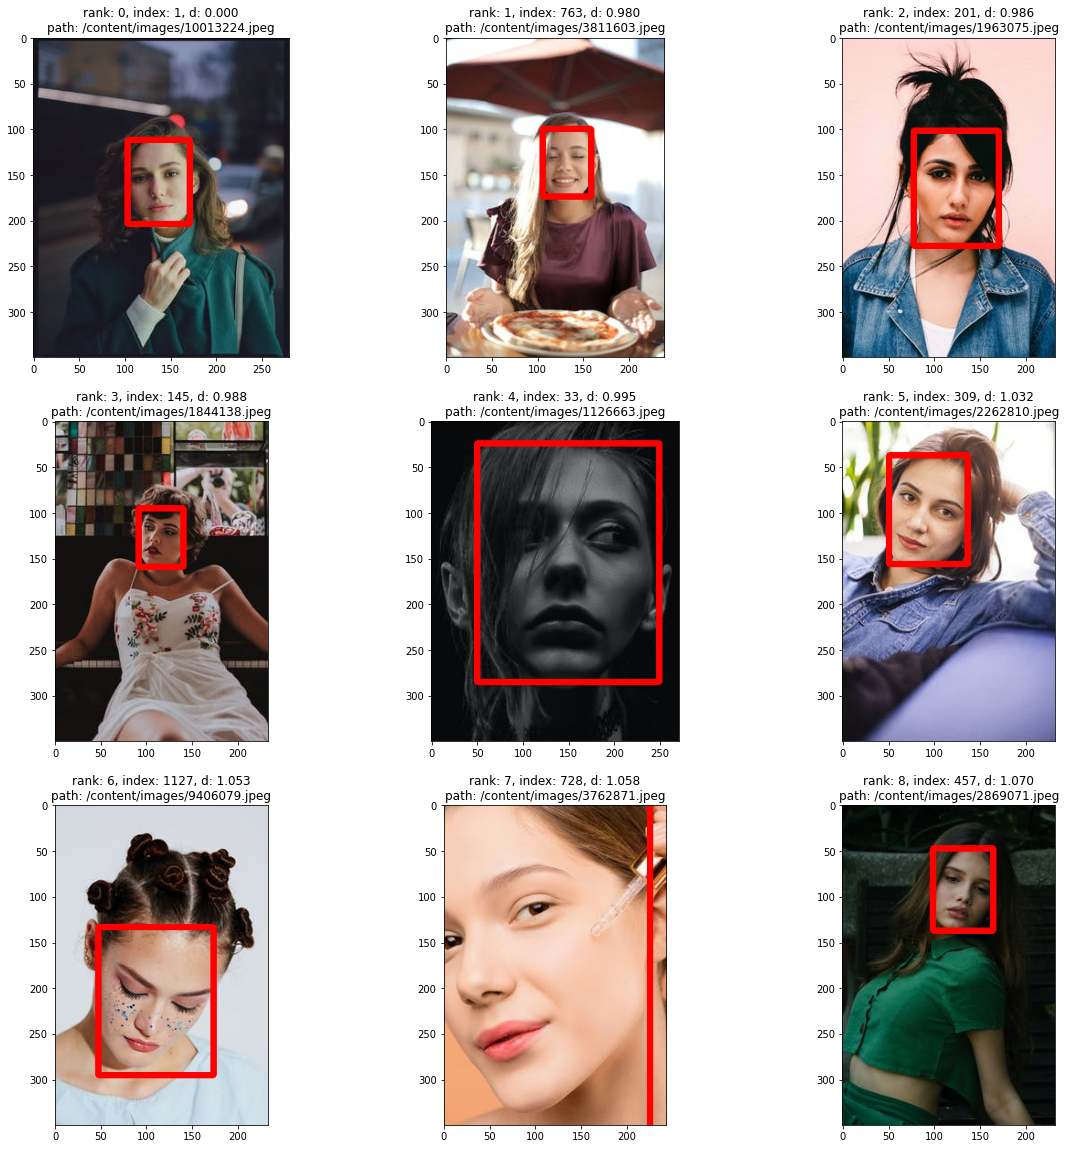

In [16]:
show_results(results, distances)